# Practical work 8: Color quantification and search by content


In this practical work session, we will:

- Develop a color based descriptor that can be applied to every image in a database
- Use this color descriptor to create a method that searches images by content: the goal is to find the images that are the most similar to a query.

In [2]:
# Load useful library

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
import scipy.ndimage
from skimage.color import rgb2hsv, hsv2rgb

# Usefull functions


def setColors(nH, nS, nV):
    """ int**3 -> Array[nH*nS*nV,3]*Array[nH,nS,nV,3]
        computes an RGB palette from a sampling of HSV values
    """
    pal1 = np.zeros((nH*nS*nV, 3))
    pal2 = np.zeros((nH, nS, nV, 3))
    tH, tS, tV = 1/(2*nH), 1/(2*nS), 1/(2*nV)

    idx = 0
    for i in range(nH):
        for j in range(nS):
            for k in range(nV):
                HSVval = np.array([[[i/nH + tH, j/nS + tS, k/nV + tV]]])
                pal1[idx, :] = hsv2rgb(HSVval)*255
                pal2[i, j, k, :] = hsv2rgb(HSVval)*255
                idx += 1
    return pal1, pal2


def viewQuantizedImage(I, pal, ax=None):
    """ Array*Array -> Array
        Display an indexed image with colors according to pal 
    """
    Iview = np.empty(I.shape)
    n, m, c = I.shape
    for i in range(n):
        for j in range(m):
            h, s, v = I[i, j, :]
            Iview[i, j, :] = pal[np.int(h), np.int(s), np.int(v), :]
    print(Iview.max())
    if ax:
        ax.imshow(Iview/255)
    else:
        plt.imshow(Iview/255)
        plt.show()


def display5mainColors(histo, pal, ax=None):
    """ Array*Array -> NoneType
        Display the 5 main colors in histo 
    """
    idx = np.argsort(histo)
    idx = idx[::-1]
    K = 5
    for i in range(K):
        Ia = np.zeros((1, 1, 3), dtype=np.uint8)
        Ia[0, 0, 0] = pal[idx[i], 0]
        Ia[0, 0, 1] = pal[idx[i], 1]
        Ia[0, 0, 2] = pal[idx[i], 2]
        if ax:
            ax.subplot(1, K, i+1)
            ax.imshow(Ia)
            ax.axis('off')
        else:
            plt.subplot(1, K, i+1)
            plt.imshow(Ia)
            plt.axis('off')
    plt.show()


def display20bestMatches(S, indexQuery):
    """ Array*int -> NoneType 
    """
    L = S[indexQuery, :]
    Idx = np.argsort(L)[::-1]
    cpt = 1
    plt.figure(figsize=(15, 10))
    for idx in Idx[:20]:
        plt.subplot(5, 4, cpt)
        indexQuery = idx
        imageName = (pathImage+listImage[indexQuery]).strip()
        plt.imshow(np.array(Image.open(imageName))/255.)
        plt.title(listImage[indexQuery])
        plt.axis('off')
        cpt += 1
    plt.show()


## Exercise 1: HSV histogram computation

Each image of the base will be represented by its color histogram in the HSV representation. We use the HSV representation rather that the RGB representation because it is a perceptual color space: two colors that look similar will have close HSV vectors.

1) Write a function ```iv = quantize(v,K)``` that returns the quantize interval of `v` considering a uniform quantization of values over the range $[0,1]$ with `K` evenly spaced intervals. For a image value v=1, the function will return K-1.

In [3]:
def quantize(I, k):
    """ float*int -> int 
    """
    if I == 1:
        return k-1
    else:
        return int(I*k)


# You can test your function with the following lines:
h = np.zeros((8))
for i in range(256):
    h[quantize(i/255., 8)] += 1
display(h)
assert (h == 32*np.ones((8))).all()


array([32., 32., 32., 32., 32., 32., 32., 32.])

2) Write a function ```[Iq, histo] = quantizeImage(I,Nh,Ns,Nv)``` that takes as input one image I of size N x M x 3 in the HSV representation and the number of quantification interval needed for H, S and V. 
    Your function will return: 
 *    ```Iq```: the quantified image for each channel, of size N x M x 3
 *   ```hist```: a 3D histogram of size Nh x Ns x Nv that counts the number of pixel for each quantification bin (iH, iS, iV)

In [4]:
def quantizeImage(I, nH, nS, nV):
    """ Array*int -> Array*Array
    """
    new_I = np.empty_like(I, dtype=int)
    hist = np.zeros((nH, nS, nV))
    l = [nH, nS, nV]
    for i in range(new_I.shape[0]):
        for j in range(new_I.shape[1]):
            new_I[i, j, 0] = quantize(I[i, j, 0], nH)
            new_I[i, j, 1] = quantize(I[i, j, 1], nS)
            new_I[i, j, 2] = quantize(I[i, j, 2], nV)
            hist[new_I[i, j, 0], new_I[i, j, 1], new_I[i, j, 2]] += 1
    return new_I, hist


3) Write a function ```normalized_histo = NormalizeHistL2(histo)``` that applies a normalization on the histogram ```histo``` according to the L2 norm.
The L2 norm of x can be computed using the function ```numpy.linalg.norm(x,2)```



In [5]:
def normalize(H):
    """ Array -> Array"""
    return H/np.linalg.norm(H, 2)


4) Test of the HSV histogram on an image: Complete the following code with your functions in order to apply it on one of the images of the base. The code will follow the following steps:
   1. Open the image and convert it into HSV representation.
   2. Compute the color palette for the display using the given ```setColors(nH, nS, nV)``` function.
   3. Compute the quantization of the image then visualize the quantized image using ```viewQuantizedImage(I,pal) ```.
   4. Transform the 3D histogram into a 1D histogram, normalize it according to L2 norm then visualize it.
   5. Display the 5 most prevalent colors on the image using ```display5mainColors(histo, pal)```.

   You can try this on the image ```Paysages67.png```with ```nH = 12```, ```nS = 3```  and ```nV = 8``` and find a result similar to Figures 1, 2, 3, and 4.

![figure1](./figs/Figure_1.png)
<center>Figure 1: Paysage67.png</center>

![figure2](./figs/Figure_2.png)
<center>Figure 2: Paysage67.png quantized</center>

![figure3](./figs/Figure_3.png)
<center>Figure 3: Histogram of HSV image (288 bins)</center>

![figure4](./figs/Figure_4.png)
<center>Figure 4: 5 main colors</center>


/tmp/ipykernel_382/803667387.py:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Iview[i, j, :] = pal[np.int(h), np.int(s), np.int(v), :]


239.0625
[(6, 1, 4), (6, 1, 3), (6, 1, 7), (5, 1, 3), (6, 0, 7)]


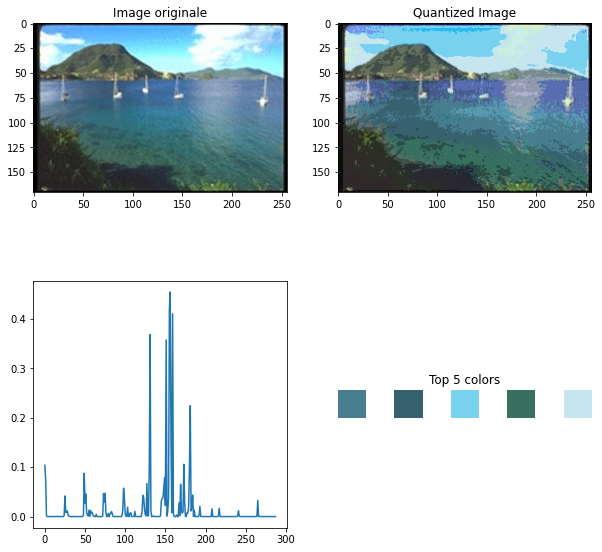

In [6]:
def hsv_hist(nH, nS, nV, nom, PathImage='./Base/'):
    filename = nom
    I = np.array(Image.open(PathImage + filename))
    I = I / 255.  # I values range in [0,1]

    fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))
    ax = ax.flatten()
    ax[0].imshow(I)
    ax[0].set_title("Image originale")

    # conversion RGB->HSV
    J = rgb2hsv(I)

    # color palette computation
    palette, palette2 = setColors(nH, nS, nV)

    # Image quantization (your function)
    Iq, histo = quantizeImage(J, nH, nS, nV)

    # Visualisation of quantized image
    viewQuantizedImage(Iq, palette2, ax=ax[1])
    ax[1].set_title("Quantized Image")

    # flat a 3D histogram to 1D
    histo = histo.flat

    # Histogram normalization (your function)
    histo = normalize(histo)

    ax[2].plot(histo)

    # Determine 5 more frequent colors
    idx_most_prevalent = (-histo).argsort()[:5]
    hsv_most_prevalent = [np.unravel_index(
        idx, (nH, nS, nV)) for idx in idx_most_prevalent]

    # display5mainColors(histo, palette, ax=ax[3])
    mainColor = np.zeros((1, 9, 3), dtype=np.uint8) + 255
    idx = np.argsort(histo)
    idx = idx[::-1]
    for i, j in enumerate(np.arange(0, 9, 2)):
        mainColor[0, j, 0] = palette[idx[i], 0]
        mainColor[0, j, 1] = palette[idx[i], 1]
        mainColor[0, j, 2] = palette[idx[i], 2]
    ax[3].imshow(mainColor/255)
    ax[3].set_title('Top 5 colors')
    ax[3].axis('off')

    print(hsv_most_prevalent)


hsv_hist(12, 3, 8, 'Paysages67.png')


5) Change the values of ```nH```, ```nS```  and ```nV``` and analyze the results. You can try with other images in the base.

/tmp/ipykernel_382/803667387.py:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Iview[i, j, :] = pal[np.int(h), np.int(s), np.int(v), :]


251.015625
[(0, 0, 0), (18, 20, 31), (14, 13, 12), (15, 14, 13), (16, 8, 31)]


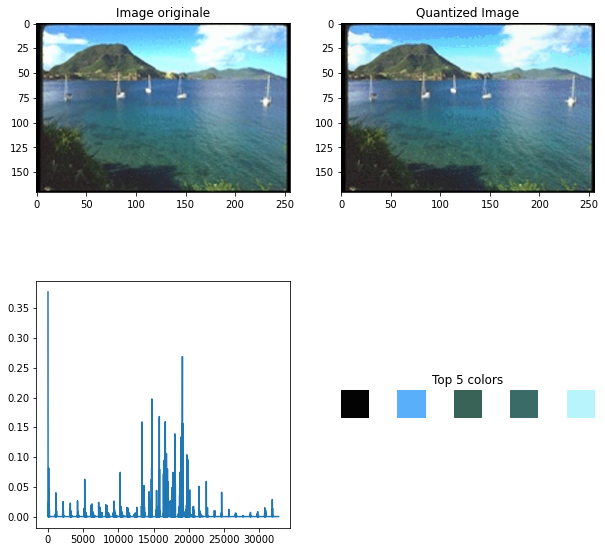

In [7]:
hsv_hist(32, 32, 32, 'Paysages67.png')

/tmp/ipykernel_382/803667387.py:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Iview[i, j, :] = pal[np.int(h), np.int(s), np.int(v), :]


212.49999999999997
[(1, 1, 1), (1, 0, 2), (1, 1, 2), (0, 0, 0), (1, 0, 1)]


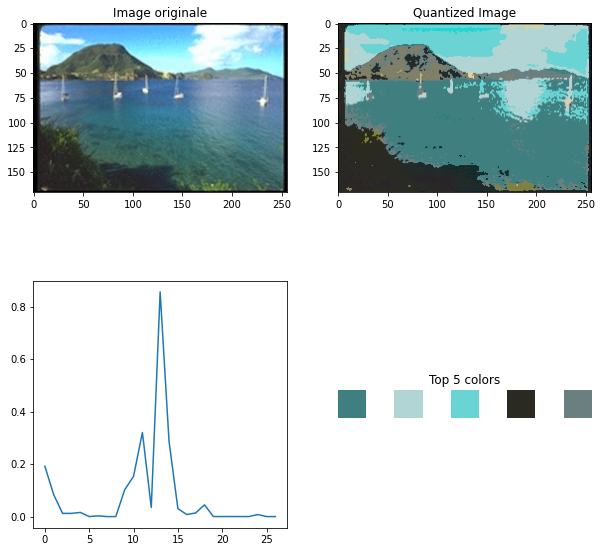

In [8]:
hsv_hist(3, 3, 3, 'Paysages67.png')


6) What can you say about the results?

**Intrusting**

**nH,nS,nV modify the number of bin created by color channel**

## Exercise 2: Similarity between images: 

In this exercice, we will compute a measure of similarity between two images from the normalized histogram. This measure of similarity will be used in order to find images that are the most similar to a given image.

### Question 2.1:  Computation of the histograms for the whole base

Complete the following script to compute the histograms for every image in the base. As the computation can take a lot of time, we will do it only one time and store the result in ```ListHisto.mat```. The results will be stored as a ```N x M``` array ```listHisto``` with ```N = 1040``` and ```M = nH x nS x nV ```. We will also save the names of the images as ```listImage```

Set ```bcomputed = False``` for the first run to compute the database histograms and then set it to 1.


In [9]:
import os
from scipy.io.matlab import loadmat, savemat
from tqdm import tqdm

#####

pathImage = './Base/'
pathDescriptors = './'

# Quantization HSV
nH = 12
nS = 3
nV = 8

bcomputed = 1  # Set to False to compute the histogramm database
if not bcomputed:
    listImage = os.listdir(pathImage)
    listImage = np.sort(listImage)
    listImage = np.char.strip(listImage)
    listHisto = []
    print('Histogram database computation ... it may take a while ...')
    for imageName in tqdm(listImage):
        if os.path.isfile(pathImage+imageName) and imageName[-4:] == '.png':
            # read image
            I = np.array(Image.open(pathImage+imageName)) / 255.

            # conversion RGB->HSV
            J = rgb2hsv(I)
            # Image quantization (your function tested in Exo 1)
            _, histo = quantizeImage(J, nH, nS, nV)

            # flat a 3D histogram in 1D
            histo = histo.flatten()

            # Normalize histogramme (your function tested in Exo 1)
            listHisto.append(normalize(histo))

    print(len(listHisto), "histograms computed")
    nomList = pathDescriptors+'ListHisto.mat'
    savemat(nomList, {'listHisto': np.array(listHisto),
                      'listImage': listImage})
else:
    print("Histogram database computation already done.")

Histogram database computation already done.


### Question 2.2: Computation of the similarity between every images in the base.

   1. Write a function ```similarityMatrix()``` or a script that performs the similarity computation for every pair of images in the base from the histograms stored in ```listHisto``` and store the result in a ```1024 x 1024``` matrix ```S```. It is possible to make the operation much faster by using only one matrix operation.

In [10]:
mat = loadmat(pathDescriptors+'ListHisto.mat')
listHisto = mat['listHisto']
listImage = mat['listImage']


def similarityMatrix(listHisto):
    return np.inner(listHisto, listHisto)


S = similarityMatrix(listHisto)
S.shape

(1040, 1040)

In [11]:
listHisto[1]

array([7.51346599e-03, 9.53432925e-03, 2.64266735e-03, 6.73621089e-04,
       1.03634014e-03, 4.66353061e-04, 5.18170068e-04, 1.96904626e-03,
       2.43539932e-03, 3.52355646e-03, 2.07268027e-03, 5.18170068e-04,
       1.55451020e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       5.28533470e-03, 2.64266735e-02, 1.41460429e-02, 2.07268027e-03,
       1.24360816e-03, 6.73621089e-04, 1.45087619e-03, 2.53903333e-03,
       5.69987075e-03, 8.23890408e-03, 1.70477952e-02, 8.54980613e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.75141483e-02, 7.93318374e-02, 5.09361177e-02, 1.10370225e-02,
       2.27994830e-03, 1.91722925e-03, 1.91722925e-03, 1.44569449e-02,
      

2. Display the matrix `S`  as an image. What can we say about this it ?

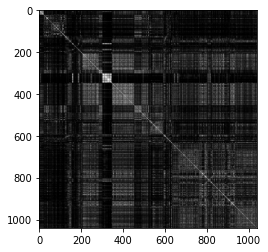

In [12]:
plt.imshow(S, cmap='gray')

Your answer: ..................

**En triant les images par ordre alphabétique pour qu'elle le soit également dans la matrice `S`, on peut clairement voir les groupes d'image similaire**

3. Assuming `S` is already computed and using function `display20bestMatches()`, test on the image `Liontigre1.png` (indexQuery = 349). You should obtain something similar to Figure 5.

![figure5.png](./figs/Figure_5.png)
<center>Figure 5: 20 best matches of image 'Liontigre1.png'</center>

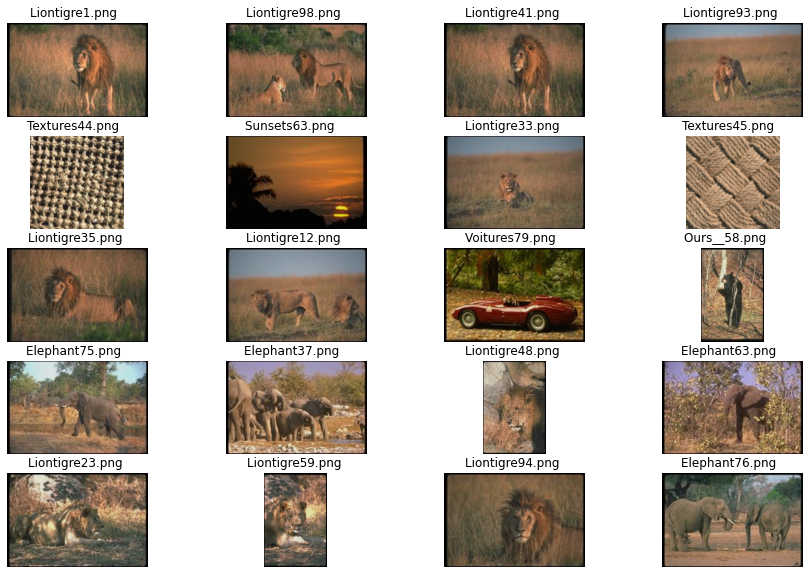

In [13]:
indexQuery = 349
display20bestMatches(S, indexQuery)
imageName = (pathImage+listImage[indexQuery]).strip()

4. Assuming `S` is already computed, generate a random query (an integer in range $[0, 1030]$), and display the 20 best matches.


'./Base/Elephant23.png'

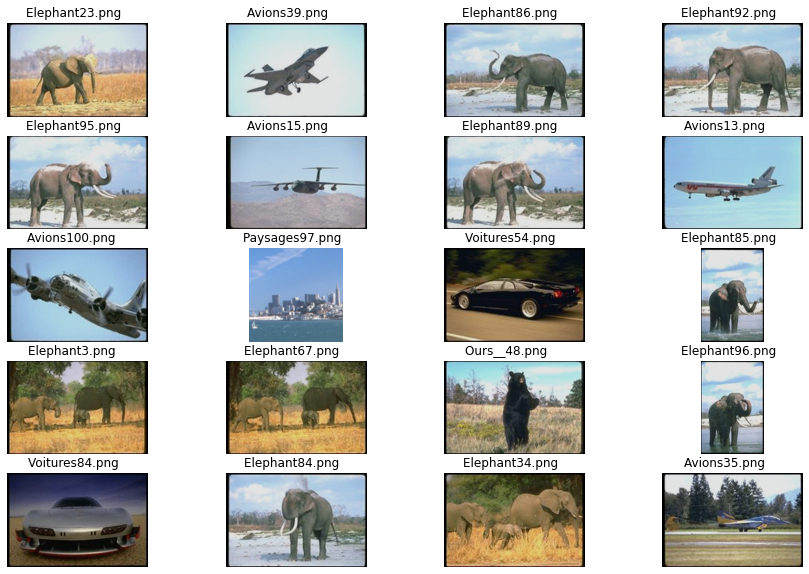

In [14]:
import random
indexQuery = random.randint(0, len(listImage))
imageName = (pathImage+listImage[indexQuery]).strip()
display(imageName)
display20bestMatches(S, indexQuery)

5. What can you say about the results ? What are the limitations and the advantages of this method ?

Your answer: ..........

**Parfois c'est bien, parfois ça n'a aucun sens**

**Mais il y a beaucoup d'autre possibilité, que ça soit pour les paramètres nH, nS, nV, ou pour la méthode de comparaison d'histogramme**

**D'après [ce post](https://stats.stackexchange.com/questions/7400/how-to-assess-the-similarity-of-two-histograms/151362#151362) il y a beaucoup de distance possible pour comparer les histogrames. Pour toutes les tester, il faudrait avoir une sorte de scoring, je vais utiliser les noms des fichier comme $y$ et faire un set de test.**

**Créons un set de test**

In [15]:
import pandas as pd

def strip_name(file_name):
    # Ours__00
    # Voitures0
    # Voitures00
    # Voitures000
    name = file_name[:-4]
    class_name = "Empty"
    if name[:4] == "Ours":
        class_name = "Ours"
    else:
        try:
            a = int(name[-3])
            class_name = name[:-3]
        except:
            try:
                a = int(name[-2])
                class_name = name[:-2]
            except:
                class_name = name[:-1]
    return class_name


imageList = os.listdir('./Base')
d = {}
for file_name in imageList:
    class_name = strip_name(file_name)
    try:
        d[class_name] += 1
    except:
        d[class_name] = 0
# n = len(imageList)
# for key in d.keys():
#     d[key] /= n
d = pd.Series(d).sort_values(ascending=False)
d

Textures     174
Liontigre    104
Paysages     104
Sunsets      101
Avions       100
Voitures      99
Elephant      95
Bestioles     82
Ours          69
Fleche        43
Portraits     25
Aeriennes     21
Personnes      7
Fondmer        2
PaxH           0
dtype: int64

Je vais tester sur les classes avec beaucoup d'exemple. En prenant les 5 première et en demandant 20 exemples semblable et vérifier les classes de ces 20 exemples semblables.

In [16]:
x_test = []
for key in d.index[:10]:  # pour les 10 premières classe
    for i in range(10):  # Je prend les 10 premières images
        file_name = key+str(i)+'.png'
        if os.path.isfile("./Base/" + file_name):
            x_test.append(file_name)
x_test

['Textures1.png',
 'Textures2.png',
 'Textures3.png',
 'Textures4.png',
 'Textures5.png',
 'Textures6.png',
 'Textures7.png',
 'Textures8.png',
 'Textures9.png',
 'Liontigre1.png',
 'Liontigre2.png',
 'Liontigre3.png',
 'Liontigre4.png',
 'Liontigre5.png',
 'Liontigre6.png',
 'Liontigre7.png',
 'Liontigre8.png',
 'Liontigre9.png',
 'Paysages1.png',
 'Paysages2.png',
 'Paysages3.png',
 'Paysages4.png',
 'Paysages5.png',
 'Paysages6.png',
 'Paysages7.png',
 'Paysages8.png',
 'Paysages9.png',
 'Sunsets1.png',
 'Sunsets2.png',
 'Sunsets3.png',
 'Sunsets4.png',
 'Sunsets5.png',
 'Sunsets6.png',
 'Sunsets7.png',
 'Sunsets8.png',
 'Sunsets9.png',
 'Avions1.png',
 'Avions2.png',
 'Avions3.png',
 'Avions4.png',
 'Avions5.png',
 'Avions6.png',
 'Avions7.png',
 'Avions8.png',
 'Avions9.png',
 'Voitures1.png',
 'Voitures2.png',
 'Voitures3.png',
 'Voitures4.png',
 'Voitures5.png',
 'Voitures6.png',
 'Voitures7.png',
 'Voitures8.png',
 'Voitures9.png',
 'Elephant1.png',
 'Elephant2.png',
 'Elephant

array([766])

'Textures1.png'

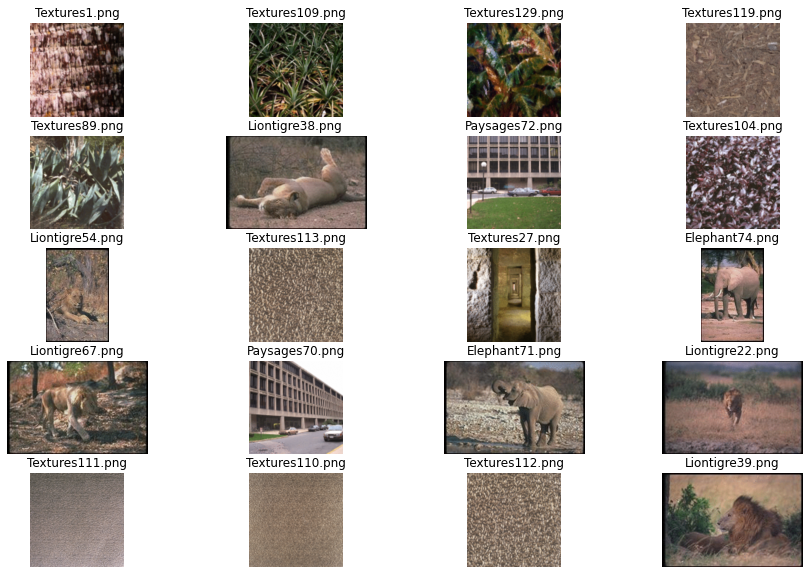

0.55

In [17]:
from icecream import ic


def score20bestMatches(S, fileName):
    """ Array*int -> NoneType 
    """
    y = strip_name(fileName)
    indexQuery = np.where(listImage == fileName)[0]
    indexQuery = int(indexQuery)
    L = S[indexQuery, :]
    Idx = np.argsort(L)[::-1]
    correct_pred = 0
    for idx in Idx[:20]:
        indexQuery = idx
        imageName = listImage[indexQuery]
        y_hat = strip_name(imageName)
        if y == y_hat:
            correct_pred += 1
    return correct_pred/20


listImage = np.sort(listImage)
listImage = np.char.strip(listImage)

fileName = 'Textures1.png'
indexQuery = np.where(listImage == fileName)[0]
display(indexQuery)
indexQuery = int(indexQuery)
display(listImage[766])
display20bestMatches(S, indexQuery)
score20bestMatches(S, fileName)

Scoring done ✅

In [18]:
def eval_test(S, x_test):
    s = 0
    for x_i in x_test:
        s += score20bestMatches(S, x_i)
    return s/len(x_test)

eval_test(S, x_test)

0.4271604938271604

In [19]:
def train(nH, nS, nV, pathImage="./Base/", pathDescriptors = './'):
    listImage = os.listdir(pathImage)
    listImage = np.sort(listImage)
    listImage = np.char.strip(listImage)
    listHisto = []
    # print('Histogram database computation ... it may take a while ...')
    for imageName in tqdm(listImage):
        if os.path.isfile(pathImage+imageName) and imageName[-4:] == '.png':
            # read image
            I = np.array(Image.open(pathImage+imageName)) / 255.

            # conversion RGB->HSV
            J = rgb2hsv(I)
            # Image quantization (your function tested in Exo 1)
            _, histo = quantizeImage(J, nH, nS, nV)

            # flat a 3D histogram in 1D
            histo = histo.flatten()

            # Normalize histogramme (your function tested in Exo 1)
            listHisto.append(normalize(histo))

    # print(len(listHisto), "histograms computed")
    nomList = pathDescriptors+f'ListHisto_{nH}_{nS}_{nV}.mat'
    savemat(nomList, {'listHisto': np.array(listHisto),
                      'listImage': np.array(listImage)})

In [20]:
import logging
import threading
import time
format = "%(asctime)s: %(message)s"
logging.basicConfig(format=format, level=logging.INFO,
                    datefmt="%H:%M:%S")

threads = list()
for nH in range(5, 16, 5):
    for nS in range(5, 16, 5):
        for nV in range(5, 16, 5):
            x = threading.Thread(target=train, args=(nH, nS, nV,))
            threads.append(x)

In [21]:
threads

[<Thread(Thread-5, initial)>,
 <Thread(Thread-6, initial)>,
 <Thread(Thread-7, initial)>,
 <Thread(Thread-8, initial)>,
 <Thread(Thread-9, initial)>,
 <Thread(Thread-10, initial)>,
 <Thread(Thread-11, initial)>,
 <Thread(Thread-12, initial)>,
 <Thread(Thread-13, initial)>,
 <Thread(Thread-14, initial)>,
 <Thread(Thread-15, initial)>,
 <Thread(Thread-16, initial)>,
 <Thread(Thread-17, initial)>,
 <Thread(Thread-18, initial)>,
 <Thread(Thread-19, initial)>,
 <Thread(Thread-20, initial)>,
 <Thread(Thread-21, initial)>,
 <Thread(Thread-22, initial)>,
 <Thread(Thread-23, initial)>,
 <Thread(Thread-24, initial)>,
 <Thread(Thread-25, initial)>,
 <Thread(Thread-26, initial)>,
 <Thread(Thread-27, initial)>,
 <Thread(Thread-28, initial)>,
 <Thread(Thread-29, initial)>,
 <Thread(Thread-30, initial)>,
 <Thread(Thread-31, initial)>]

In [22]:
len(threads)

27

In [23]:
# for i in threads:
#     i.start()
#     time.sleep(1)

**J'ai trop de problème pour le multithreader, entre wsl et les notebooks qui bug**

**J'imagine que vous voyez ce que j'allais faire, trouver les meilleurs hyperparametre ensuite, avec quelque plot**